In [7]:
from time import time

import numpy as np

from spineq.data.census import PopulationDataset, WorkplaceDataset
from spineq.data.group import LocalAuthority
from spineq.mappings import lad20nm_to_lad20cd
from spineq.opt.coverage import ExponentialCoverage
from spineq.opt.greedy import Greedy
from spineq.opt.objectives import Column, CombinedObjectives
from spineq.opt.result import SingleNetworkResult
from spineq.plot.plotting import plot_optimisation_result

## Parameters

In [2]:
lad20nm = "Newcastle upon Tyne"
lad20cd = lad20nm_to_lad20cd(lad20nm)

n_sensors = 20
theta = 500

child_age = 16
elder_age = 65

pop_total_weight = 1
pop_child_weight = 0
pop_elder_weight = 0
work_weight = 0

## Create coverage objective

In [5]:
total = PopulationDataset(lad20cd).to_total()
child = (
    PopulationDataset(lad20cd).filter_age(high=child_age, name="children").to_total()
)
elder = PopulationDataset(lad20cd).filter_age(low=elder_age, name="elderly").to_total()
work = WorkplaceDataset(lad20cd)
la = LocalAuthority(lad20cd, datasets=[total, child, elder, work])

cov = ExponentialCoverage.from_la(la, theta)

objs = CombinedObjectives(
    la,
    [
        Column(total.name, "total", pop_total_weight),
        Column(child.name, "total", pop_child_weight),
        Column(elder.name, "total", pop_elder_weight),
        Column(work.name, "workers", work_weight),
    ],
    cov,
)

## Baseline 1: Place sensors in output areas with the largest weights

If weight given only to total population, this is equivalent to placing sensors in the output areas with the highest populations.

Time: 0.01s


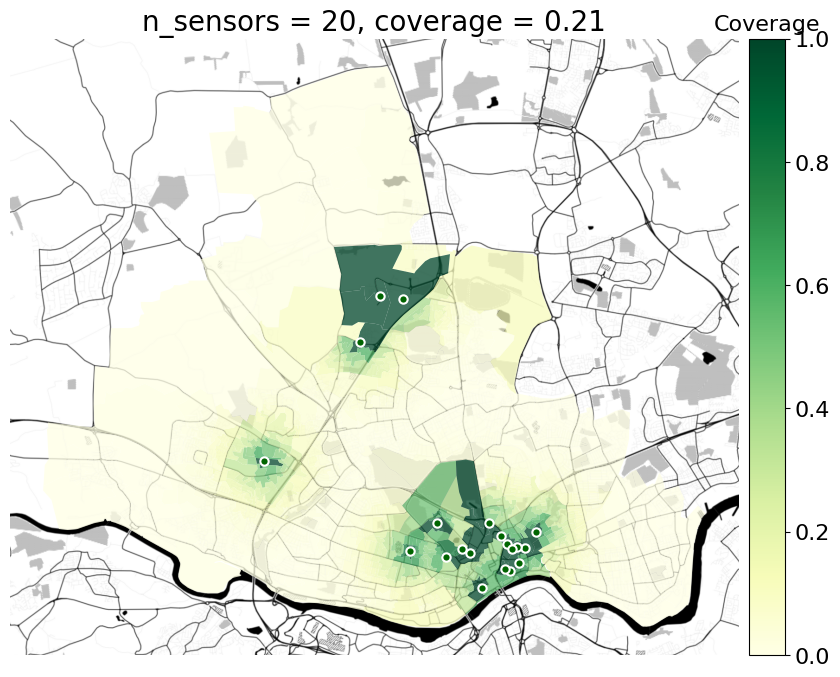

In [16]:
start_time = time()

top_idx = np.argsort(objs.weights)[-n_sensors:]
sensors = np.zeros(la.n_oa11cd)
sensors[top_idx] = 1
result = SingleNetworkResult(objs, n_sensors, sensors, objs.fitness(sensors))

print(f"Time: {time()-start_time:.2f}s")

plot_optimisation_result(result)

## Baseline 2: Place sensors in random output areas

Time: 0.00s


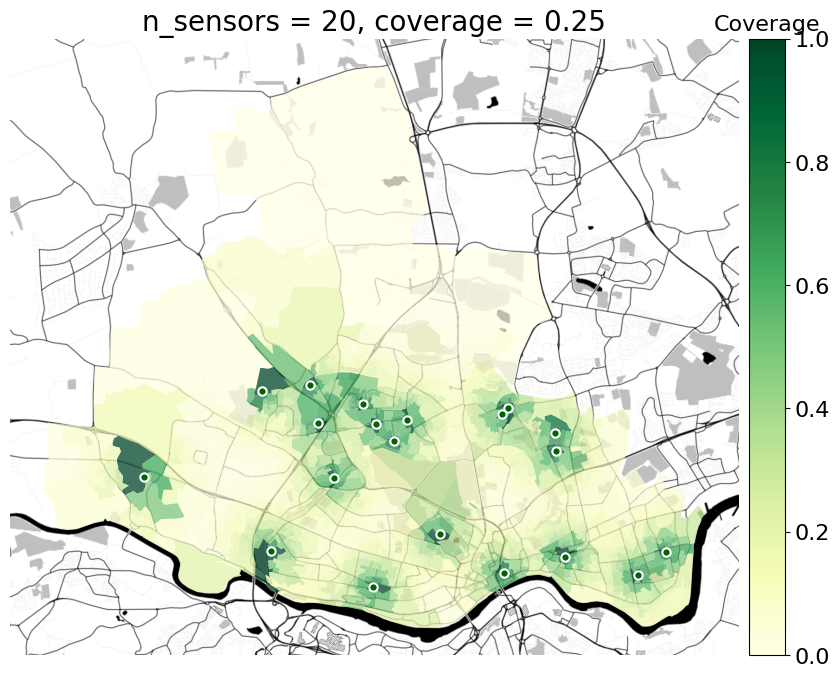

In [17]:
start_time = time()

# add sensors at random location
# (without replacement so sensors all at different locations)
sensors_idx = np.random.choice(
    la.n_oa11cd,
    size=n_sensors,
    replace=False,
)

sensors = np.zeros(la.n_oa11cd)
sensors[sensors_idx] = 1
result = SingleNetworkResult(objs, n_sensors, sensors, objs.fitness(sensors))

print(f"Time: {time()-start_time:.2f}s")

plot_optimisation_result(result)

## Baseline 3: Best of many randomly generated networks

Time: 2.14s


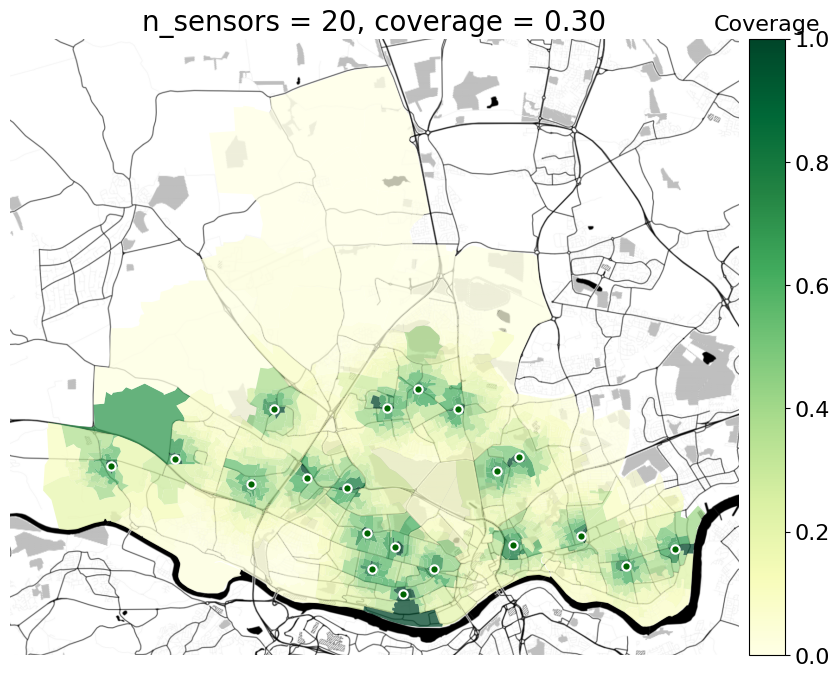

In [18]:
n_attempts = 1000

start_time = time()

best_result = None

for _ in range(n_attempts):
    # add sensors at random location
    # (without replacement so sensors all at different locations)
    sensors_idx = np.random.choice(
        la.n_oa11cd,
        size=n_sensors,
        replace=False,
    )

    sensors = np.zeros(la.n_oa11cd)
    sensors[sensors_idx] = 1

    result = SingleNetworkResult(objs, n_sensors, sensors, objs.fitness(sensors))
    if not best_result or result.total_coverage > best_result.total_coverage:
        best_result = result

print(f"Time: {time()-start_time:.2f}s")

plot_optimisation_result(best_result)

## Greedy: Place sensors one by one in the place that maximises total coverage

Placing sensor 1 out of 20 ... coverage = 0.04
Placing sensor 2 out of 20 ... coverage = 0.08
Placing sensor 3 out of 20 ... coverage = 0.10
Placing sensor 4 out of 20 ... coverage = 0.13
Placing sensor 5 out of 20 ... coverage = 0.15
Placing sensor 6 out of 20 ... coverage = 0.17
Placing sensor 7 out of 20 ... coverage = 0.19
Placing sensor 8 out of 20 ... coverage = 0.21
Placing sensor 9 out of 20 ... coverage = 0.23
Placing sensor 10 out of 20 ... coverage = 0.24
Placing sensor 11 out of 20 ... coverage = 0.25
Placing sensor 12 out of 20 ... coverage = 0.27
Placing sensor 13 out of 20 ... coverage = 0.28
Placing sensor 14 out of 20 ... coverage = 0.29
Placing sensor 15 out of 20 ... coverage = 0.30
Placing sensor 16 out of 20 ... coverage = 0.31
Placing sensor 17 out of 20 ... coverage = 0.32
Placing sensor 18 out of 20 ... coverage = 0.33
Placing sensor 19 out of 20 ... coverage = 0.34
Placing sensor 20 out of 20 ... coverage = 0.35
Time (also includes weight and coverage calculati

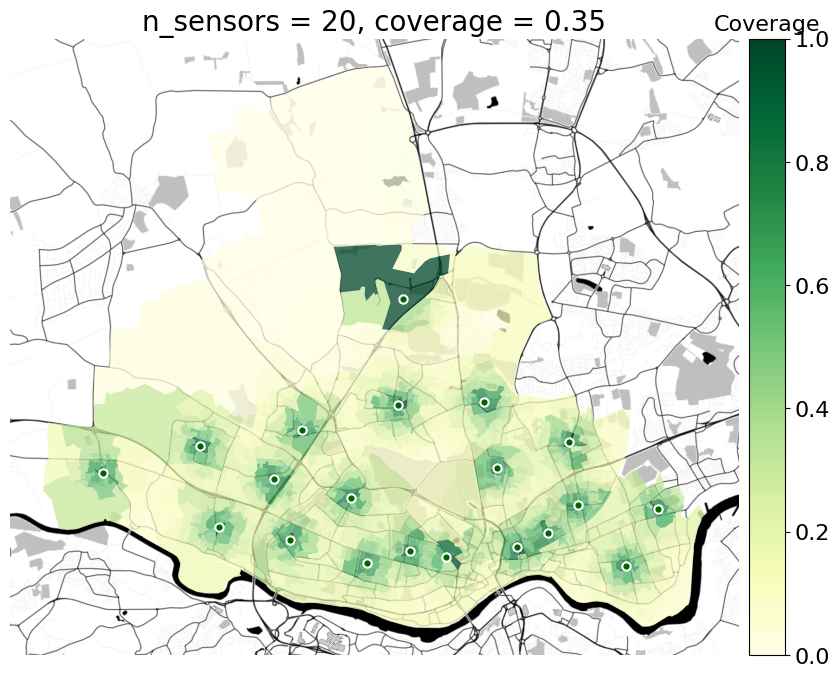

In [20]:
start_time = time()

greedy = Greedy()
result = greedy.run(objs, n_sensors)

print(f"Time (also includes weight and coverage calculation): {time()-start_time:.2f}s")

plot_optimisation_result(result)